In [1]:
import sys
sys.path.append('../')
from utils import *
from model import *

In [2]:
data_dir = '/datadrive/data_med/'
batch_size = 256
batch_num  = 128
epoch_num  = 200
samp_num   = 7

device = torch.device("cuda:3")
graph = dill.load(open(data_dir + 'graph.pk', 'rb'))

In [3]:
train_range = {t: True for t in graph.times if t != None and t < 2015}
valid_range = {t: True for t in graph.times if t != None and t >= 2015  and t <= 2016}
test_range  = {t: True for t in graph.times if t != None and t > 2016}

In [4]:
def pf_sample(seed, papers, pairs, t_range, batch_size, test = False):
    np.random.seed(seed)
    _time = np.random.choice(list(papers.keys()))
    sampn = min(len(papers[_time]), batch_size)
    pids = np.array(papers[_time])[np.random.choice(len(papers[_time]), sampn, replace = False)]
    fids = []
    edge = defaultdict(lambda: {})
    for x_id, p_id in enumerate(pids):
        f_ids = pairs[p_id]
        for f_id in f_ids:
            if f_id not in fids:
                fids += [f_id]
            edge[x_id][fids.index(f_id)] = True
    pids = np.stack([pids, np.repeat([_time], sampn)]).T
    fids = np.stack([fids, np.repeat([_time], len(fids))]).T
 
    feature, times, edge_list, _ = sample_subgraph(graph, t_range, \
                inp = {'paper': pids, 'venue': fids}, sampled_depth = 3, sampled_number = 100)

    el = []
    for i in edge_list['paper']['venue']['rev_PV_Journal']:
        if i[0] in edge and i[1] in edge[i[0]]:
            continue
        el += [i]
    edge_list['paper']['venue']['rev_PV_Journal'] = el

    el = []
    for i in edge_list['venue']['paper']['PV_Journal']:
        if i[1] in edge and i[0] in edge[i[1]]:
            continue
        el += [i]
    edge_list['venue']['paper']['PV_Journal'] = el
    
    
    node_feature, node_type, edge_time, edge_index, edge_type, node_dict, edge_dict = \
            to_torch(feature, times, edge_list, graph)
    '''
        Trace the paper_id and venue_id by its own index plus the type start index
    '''
    paper_ids = np.arange(len(pids)) + node_dict['paper'][0]
    venue_ids = np.arange(len(fids)) + node_dict['venue'][0]
    ylabel = torch.zeros(sampn, len(cand_list))
    for x_id, p_id in enumerate(pids[:,0]):
        for f_id in pairs[p_id]:
            ylabel[x_id][cand_list.index(f_id)] = 1
    ylabel /= ylabel.sum(axis=1).view(-1, 1)
    return node_feature, node_type, edge_time, edge_index, edge_type, venue_ids, paper_ids, ylabel
    
def prepare_data(pool, process_ids):
    jobs = []
    for process_id in process_ids[:-1]:
        p = pool.apply_async(pf_sample, args=(np.random.randint(2**32 - 1), train_papers, \
                                               train_pairs, train_range, batch_size))
        jobs.append(p)
    p = pool.apply_async(pf_sample, args=(np.random.randint(2**32 - 1), valid_papers, \
                                           valid_pairs, valid_range, batch_size))
    jobs.append(p)
    return jobs

In [5]:
from torch_geometric.nn import GATConv
class GNN(nn.Module):
    def __init__(self, in_dim, n_hid, num_types, n_layers, dropout = 0.3):
        super(GNN, self).__init__()
        self.gcs = nn.ModuleList()
        self.num_types = num_types
        self.in_dim    = in_dim
        self.n_hid     = n_hid
        self.aggregat_ws   = nn.ModuleList()
        self.drop          = nn.Dropout(dropout)
        for t in range(num_types):
            self.aggregat_ws.append(nn.Linear(in_dim, n_hid))
        for l in range(n_layers):
            self.gcs.append(GATConv(n_hid, n_hid // 4, heads=4))
    def forward(self, node_feature, node_type, edge_index):
        res = torch.zeros(node_feature.size(0), self.n_hid).to(node_feature.device)
        for t_id in range(self.num_types):
            aggregat_w = self.aggregat_ws[t_id]
            idx = (node_type == t_id)
            if idx.sum() == 0:
                continue
            res[idx] = torch.tanh(aggregat_w(node_feature[idx]))
        meta_xs = self.drop(res)
        del res
        for gc in self.gcs:
            meta_xs = self.drop(F.relu(gc(meta_xs, edge_index)))
        return meta_xs

In [6]:
'''
Paper-Venue
'''
paper_ser = {}

train_pairs = {}
valid_pairs = {}
test_pairs  = {}

train_papers = {_time: {} for _time in train_range}
valid_papers = {_time: {} for _time in valid_range}
test_papers  = {_time: {} for _time in test_range}

for f_id in graph.edge_list['venue']['paper']['PV_Journal']:
    for p_id in graph.edge_list['venue']['paper']['PV_Journal'][f_id]:
        _time = graph.edge_list['venue']['paper']['PV_Journal'][f_id][p_id]
        if _time in train_range:
            if p_id not in train_pairs:
                train_pairs[p_id] = []
            train_pairs[p_id] += [f_id]
            train_papers[_time][p_id] = True
        elif _time in valid_range:
            if p_id not in valid_pairs:
                valid_pairs[p_id] = []
            valid_pairs[p_id] += [f_id]
            valid_papers[_time][p_id] = True
        else:
            if p_id not in test_pairs:
                test_pairs[p_id] = []
            test_pairs[p_id] += [f_id]
            test_papers[_time][p_id] = True
for _time in list(train_papers.keys()):
    if len(train_papers[_time]) < batch_size // 2:
        train_papers.pop(_time)
    else:
        train_papers[_time] = np.array(list(train_papers[_time].keys()))
for _time in list(valid_papers.keys()):
    if len(valid_papers[_time]) < batch_size // 2:
        valid_papers.pop(_time)
    else:
        valid_papers[_time] = np.array(list(valid_papers[_time].keys()))
for _time in list(test_papers.keys()):
    if len(test_papers[_time]) < batch_size // 2:
        test_papers.pop(_time)
    else:
        test_papers[_time] = np.array(list(test_papers[_time].keys()))
print(len(train_pairs))

633550


In [7]:
types = graph.get_types()
cand_list = list(graph.edge_list['venue']['paper']['PV_Journal'])
gnn = GNN(in_dim = len(graph.node_feature['paper']['emb'][0]) + 401, n_hid = 256, n_layers = 3, num_types = len(types)).to(device)
classifier = Classifier(256, len(cand_list)).to(device)
model = nn.Sequential(gnn, classifier)
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000, eta_min=1e-6)

In [ ]:
stats = []
pool = mp.Pool(4)
process_ids = np.arange(batch_num // 4)
st = time.time()
jobs = prepare_data(pool, process_ids)
train_step = 1500
best_val   = 0
res = []
criterion = nn.KLDivLoss(reduction='batchmean')
for epoch in np.arange(epoch_num)+1:
    '''
        Prepare Training and Validation Data
    '''
    train_data = [job.get() for job in jobs[:-1]]
    valid_data = jobs[-1].get()
    pool.close()
    pool.join()
    pool = mp.Pool(4)
    jobs = prepare_data(pool, process_ids)
    et = time.time()
    print('Data Preparation: %.1fs' % (et - st))
    
    
    model.train()
    train_losses = []
    for batch in np.arange(5):
        for node_feature, node_type, edge_time, edge_index, edge_type, venue_ids, paper_ids, ylabel in train_data:
            node_rep = gnn.forward(node_feature.to(device), node_type.to(device), edge_index.to(device))
            res  = classifier.forward(node_rep[paper_ids])
            loss = criterion(res, ylabel.to(device))
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            train_losses += [loss.cpu().detach().tolist()]
            train_step += 1
            scheduler.step(train_step)
    '''
        Valid
    '''
    model.eval()
    with torch.no_grad():
        node_feature, node_type, edge_time, edge_index, edge_type, venue_ids, paper_ids, ylabel = valid_data
        node_rep = gnn.forward(node_feature.to(device), node_type.to(device), edge_index.to(device))
        res  = classifier.forward(node_rep[paper_ids])
        loss = criterion(res, ylabel.to(device))
        valid_res = []

        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            valid_res += [ai[bi].tolist()]
        valid_ndcg = np.average([ndcg_at_k(resi, len(resi)) for resi in valid_res])
        if valid_ndcg > best_val:
            best_val = valid_ndcg
            torch.save(model, './save/gat.pt')
        st = time.time()
        print(("Epoch: %d (%.1fs)  LR: %.5f Train Loss: %.2f  Valid Loss: %.2f  Valid NDCG: %.4f") % \
              (epoch, (st-et), optimizer.param_groups[0]['lr'], np.average(train_losses), loss.cpu().detach().tolist(),\
              valid_ndcg))
        stats += [[np.average(train_losses), loss.cpu().detach().tolist()]]
        if epoch % 5 == 0:
            '''
                Test
            '''
            _time = np.random.choice(list(test_papers.keys()))
            node_feature, node_type, edge_time, edge_index, edge_type, venue_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                           test_pairs, test_range, batch_size, test=True)
            paper_rep = gnn.forward(node_feature.to(device), node_type.to(device), edge_index.to(device))[paper_ids]
            res = classifier.forward(paper_rep)
            test_res = []
            for ai, bi in zip(ylabel, res.argsort(descending = True)):
                test_res += [ai[bi].tolist()]
            test_ndcg = np.average([ndcg_at_k(resi, len(resi)) for resi in test_res])
            print("Test NDCG: " + str(test_ndcg))
    del train_data, valid_data

Data Preparation: 293.1s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 (47.8s)  LR: 0.00073 Train Loss: 6.29  Valid Loss: 8.18  Valid NDCG: 0.1367
Data Preparation: 245.3s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 2 (48.9s)  LR: 0.00091 Train Loss: 4.95  Valid Loss: 8.48  Valid NDCG: 0.1409
Data Preparation: 236.7s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 3 (48.9s)  LR: 0.00100 Train Loss: 4.23  Valid Loss: 7.58  Valid NDCG: 0.1723
Data Preparation: 241.3s
Epoch: 4 (48.8s)  LR: 0.00096 Train Loss: 3.31  Valid Loss: 7.67  Valid NDCG: 0.1534
Data Preparation: 233.8s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 5 (48.6s)  LR: 0.00082 Train Loss: 3.58  Valid Loss: 7.21  Valid NDCG: 0.2127
Test NDCG: 0.24013482955613502
Data Preparation: 244.9s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 6 (46.8s)  LR: 0.00061 Train Loss: 3.48  Valid Loss: 6.90  Valid NDCG: 0.2611
Data Preparation: 240.7s
Epoch: 7 (48.3s)  LR: 0.00037 Train Loss: 2.97  Valid Loss: 6.97  Valid NDCG: 0.2169
Data Preparation: 236.4s
Epoch: 8 (48.6s)  LR: 0.00016 Train Loss: 2.75  Valid Loss: 6.75  Valid NDCG: 0.2578
Data Preparation: 236.7s
Epoch: 9 (51.3s)  LR: 0.00003 Train Loss: 2.51  Valid Loss: 6.97  Valid NDCG: 0.2061
Data Preparation: 238.6s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 10 (49.7s)  LR: 0.00001 Train Loss: 3.22  Valid Loss: 6.49  Valid NDCG: 0.2699
Test NDCG: 0.2935338019677492
Data Preparation: 241.4s
Epoch: 11 (48.7s)  LR: 0.00010 Train Loss: 3.22  Valid Loss: 7.08  Valid NDCG: 0.2507
Data Preparation: 236.4s
Epoch: 12 (45.9s)  LR: 0.00029 Train Loss: 3.70  Valid Loss: 6.94  Valid NDCG: 0.2179
Data Preparation: 237.9s
Epoch: 13 (48.3s)  LR: 0.00052 Train Loss: 2.54  Valid Loss: 7.06  Valid NDCG: 0.2662
Data Preparation: 242.1s
Epoch: 14 (48.5s)  LR: 0.00075 Train Loss: 2.96  Valid Loss: 6.92  Valid NDCG: 0.2158
Data Preparation: 237.1s
Epoch: 15 (48.1s)  LR: 0.00093 Train Loss: 3.16  Valid Loss: 6.88  Valid NDCG: 0.2685
Test NDCG: 0.2626754554110518
Data Preparation: 240.0s
Epoch: 16 (48.1s)  LR: 0.00100 Train Loss: 2.80  Valid Loss: 7.03  Valid NDCG: 0.2650
Data Preparation: 236.1s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 17 (50.1s)  LR: 0.00096 Train Loss: 2.45  Valid Loss: 6.46  Valid NDCG: 0.2759
Data Preparation: 236.6s
Epoch: 18 (51.2s)  LR: 0.00081 Train Loss: 1.81  Valid Loss: 6.84  Valid NDCG: 0.2681
Data Preparation: 237.9s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 19 (46.6s)  LR: 0.00059 Train Loss: 2.86  Valid Loss: 6.31  Valid NDCG: 0.2852
Data Preparation: 237.0s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 20 (45.4s)  LR: 0.00035 Train Loss: 2.34  Valid Loss: 5.33  Valid NDCG: 0.3913
Test NDCG: 0.3547294713229439
Data Preparation: 231.2s
Epoch: 21 (47.2s)  LR: 0.00014 Train Loss: 2.64  Valid Loss: 5.99  Valid NDCG: 0.3460
Data Preparation: 235.5s
Epoch: 22 (49.4s)  LR: 0.00002 Train Loss: 2.68  Valid Loss: 6.29  Valid NDCG: 0.3095
Data Preparation: 242.3s
Epoch: 23 (50.0s)  LR: 0.00001 Train Loss: 1.94  Valid Loss: 6.69  Valid NDCG: 0.2677
Data Preparation: 235.1s
Epoch: 24 (48.9s)  LR: 0.00012 Train Loss: 2.25  Valid Loss: 6.56  Valid NDCG: 0.2986
Data Preparation: 233.7s
Epoch: 25 (48.8s)  LR: 0.00031 Train Loss: 2.48  Valid Loss: 5.90  Valid NDCG: 0.3516
Test NDCG: 0.34918897982411756
Data Preparation: 231.8s
Epoch: 26 (48.9s)  LR: 0.00055 Train Loss: 2.49  Valid Loss: 5.94  Valid NDCG: 0.3269
Data Preparation: 241.5s
Epoch: 27 (48.4s)  LR: 0.00077 Train Loss: 2.49  Valid Loss: 6.13  Valid NDCG: 0.3197
Data Preparation: 233.1s
Epoch: 28 (48.5s)  LR: 0.00094 Train Loss: 2.12  Va

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 43 (49.4s)  LR: 0.00093 Train Loss: 1.87  Valid Loss: 5.25  Valid NDCG: 0.4246
Data Preparation: 241.4s
Epoch: 44 (47.9s)  LR: 0.00077 Train Loss: 2.07  Valid Loss: 6.38  Valid NDCG: 0.3086
Data Preparation: 233.7s
Epoch: 45 (48.0s)  LR: 0.00054 Train Loss: 1.91  Valid Loss: 5.94  Valid NDCG: 0.3422
Test NDCG: 0.413524518867897
Data Preparation: 233.3s
Epoch: 46 (46.5s)  LR: 0.00030 Train Loss: 2.21  Valid Loss: 6.17  Valid NDCG: 0.3408
Data Preparation: 244.1s
Epoch: 47 (46.3s)  LR: 0.00011 Train Loss: 2.02  Valid Loss: 5.86  Valid NDCG: 0.3662
Data Preparation: 238.0s
Epoch: 48 (47.0s)  LR: 0.00001 Train Loss: 1.83  Valid Loss: 6.22  Valid NDCG: 0.3105
Data Preparation: 247.3s
Epoch: 49 (48.4s)  LR: 0.00002 Train Loss: 1.84  Valid Loss: 5.45  Valid NDCG: 0.4199
Data Preparation: 242.5s
Epoch: 50 (46.8s)  LR: 0.00015 Train Loss: 2.28  Valid Loss: 6.01  Valid NDCG: 0.3578
Test NDCG: 0.460522856846999
Data Preparation: 249.3s
Epoch: 51 (47.9s)  LR: 0.00035 Train Loss: 1.76  Valid

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 52 (44.2s)  LR: 0.00059 Train Loss: 2.46  Valid Loss: 5.17  Valid NDCG: 0.4291
Data Preparation: 233.7s
Epoch: 53 (46.7s)  LR: 0.00081 Train Loss: 2.28  Valid Loss: 5.87  Valid NDCG: 0.3711
Data Preparation: 242.7s
Epoch: 54 (48.8s)  LR: 0.00096 Train Loss: 1.60  Valid Loss: 5.86  Valid NDCG: 0.3477
Data Preparation: 237.2s
Epoch: 55 (47.0s)  LR: 0.00100 Train Loss: 2.13  Valid Loss: 5.97  Valid NDCG: 0.3169
Test NDCG: 0.46898346454759227
Data Preparation: 239.3s
Epoch: 56 (47.5s)  LR: 0.00092 Train Loss: 1.81  Valid Loss: 6.00  Valid NDCG: 0.3775
Data Preparation: 237.2s
Epoch: 57 (47.5s)  LR: 0.00075 Train Loss: 1.80  Valid Loss: 5.60  Valid NDCG: 0.3531
Data Preparation: 246.2s
Epoch: 58 (47.7s)  LR: 0.00052 Train Loss: 1.74  Valid Loss: 6.35  Valid NDCG: 0.3160
Data Preparation: 238.9s
Epoch: 59 (46.2s)  LR: 0.00028 Train Loss: 1.90  Valid Loss: 5.84  Valid NDCG: 0.3529
Data Preparation: 237.8s
Epoch: 60 (46.7s)  LR: 0.00010 Train Loss: 2.25  Valid Loss: 5.06  Valid NDCG: 0.

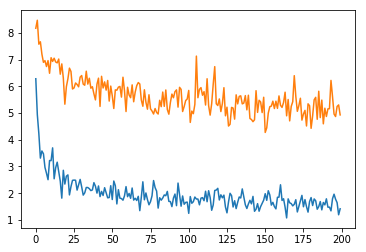

In [13]:
stats = np.array(stats)
plt.plot(stats[:,0])
plt.plot(stats[:,1])
plt.show()

In [14]:
model.eval()
gnn, classifier = model
with torch.no_grad():
    test_res = []
    for _ in range(10):
        _time = np.random.choice(list(test_papers.keys()))
        node_feature, node_type, edge_time, edge_index, edge_type, venue_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                       test_pairs, test_range, batch_size, test=True)
        paper_rep = gnn.forward(node_feature.to(device), node_type.to(device), edge_index.to(device))[paper_ids]
        res = classifier.forward(paper_rep)
        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            test_res += [ai[bi].tolist()]
    test_ndcg = [ndcg_at_k(resi, len(resi)) for resi in test_res]
    print(np.average(test_ndcg), np.var(test_ndcg))
    test_mrr = mean_reciprocal_rank(test_res)
    print(np.average(test_mrr), np.var(test_mrr))

0.5426824121419349 0.16754782310202931
0.43640684543455743 0.21315936975486233


In [15]:
best_model = torch.load('./save/gat.pt')

In [16]:
best_model.eval()
gnn, classifier = best_model
with torch.no_grad():
    test_res = []
    for _ in range(10):
        _time = np.random.choice(list(test_papers.keys()))
        node_feature, node_type, edge_time, edge_index, edge_type, venue_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                       test_pairs, test_range, batch_size, test=True)
        paper_rep = gnn.forward(node_feature.to(device), node_type.to(device), edge_index.to(device))[paper_ids]
        res = classifier.forward(paper_rep)
        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            test_res += [ai[bi].tolist()]
    test_ndcg = [ndcg_at_k(resi, len(resi)) for resi in test_res]
    print(np.average(test_ndcg), np.var(test_ndcg))
    test_mrr = mean_reciprocal_rank(test_res)
    print(np.average(test_mrr), np.var(test_mrr))

0.5202430761941716 0.16528712842957732
0.41505480926543986 0.21173632759707592
